In [1]:
import os
import pandas as pd

from pyspark import SparkContext, SparkConf
from pyspark.sql import SparkSession
import pyspark.sql.functions as F

import sagemaker
from sagemaker import get_execution_role
import sagemaker_pyspark

#Visualizaciones y Varios
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

import boto3
role = get_execution_role()

In [2]:
jars = sagemaker_pyspark.classpath_jars()
classpath = ":".join(sagemaker_pyspark.classpath_jars())
spark = (SparkSession.builder
         .config("spark.driver.extraClassPath", classpath)
         .config("spark.executor.memory","60g")
         .config("spark.driver.memory","60g")
         .config("spark.driver.maxResultSize", "0")
         .master("local[*]").getOrCreate())

spark.conf.set("spark.sql.caseSensitive", "true")

In [3]:
spark

### Carga de datos pre-procesados

In [5]:
SDF = spark.read.parquet('tweets_politicos')

In [6]:
SDF.show(1, False, True)
SDF.count()

-RECORD 0-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
 id_str      | 1134966472260931585                                                                                                                                                                                                            
 hashtags    | [CuentaPública, ChileenMarcha]                                                                                                                                                                                                 
 screen_name | _alecandia                                                                                                                                                                                                                     
 target_id   | 57                           

170306

### Que partidos / coaliciones tienen más tweets (candidatos al experimento)

In [6]:
tweets_partidos = (
    SDF.select('Partido', 'text')
    .groupby('Partido')
    .agg(F.count('text'))
    .toPandas()
    .sort_values('count(text)',ascending=False))
    
tweets_coalicion = (
    SDF.select('Coalicion', 'text')
    .groupby('Coalicion')
    .agg(F.count('text'))
    .toPandas()
    .sort_values('count(text)',ascending=False))

Text(0.5, 1.0, 'Suma de tweets Por Coalición')

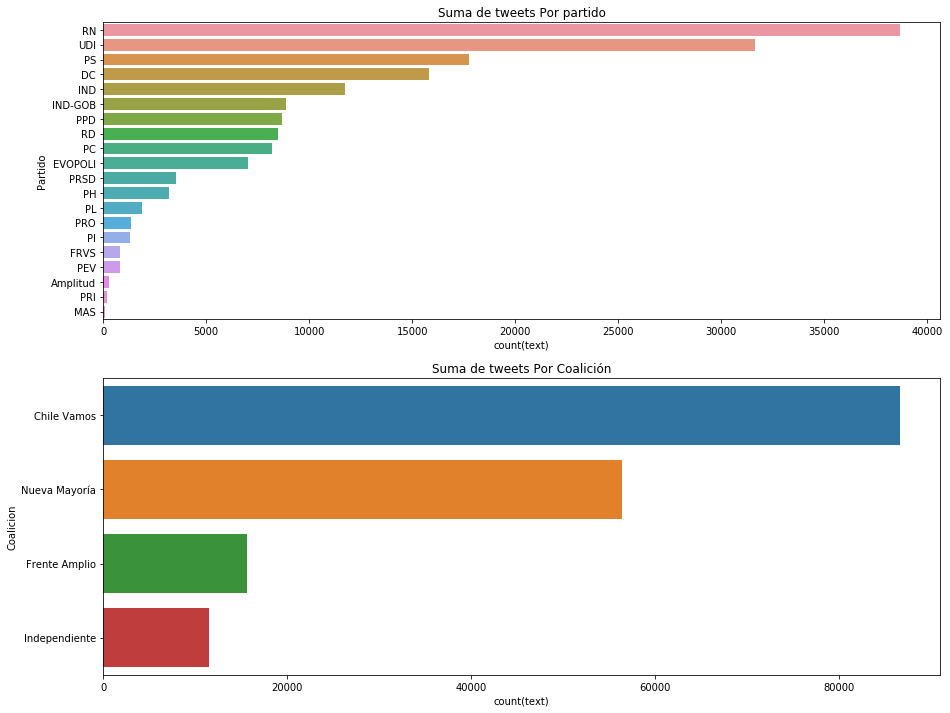

In [7]:
fig, ax = plt.subplots(2,1,figsize=(15,12))
sns.barplot(y='Partido', x='count(text)', orient='h', ax = ax[0], data=tweets_partidos).set_title('Suma de tweets Por partido')
sns.barplot(y='Coalicion', x='count(text)', orient='h', ax = ax[1], data=tweets_coalicion).set_title('Suma de tweets Por Coalición')

### Que tan diferentes son las composiciones de los tweets?

In [10]:
from pyspark.ml.feature import Tokenizer,StopWordsRemover

In [7]:
SDFv2 = ( SDF.select('screen_name','text_clean', 'Partido', 'Coalicion', 'dt')
    #.withColumn('text_clean',F.regexp_replace('text_clean', '[\.\,\;\:]','' ))
)

In [8]:
SDFv2.show(2, False, True)

-RECORD 0----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
 screen_name | _alecandia                                                                                                                                                                                                                                                                              
 text_clean  | Ya estamos en el Congreso con los subses @CarolCBown y @s_villarrealb para participar de la #CuentaPública de nuestro Presidente @sebastianpinera #ChileenMarcha 💪🇨🇱                                                                                                                 
 Partido     | IND-GOB                                                                                             

In [11]:
Tok=Tokenizer().setInputCol("text_clean").setOutputCol("tokenized")
stopwords = StopWordsRemover.loadDefaultStopWords("spanish")
stops=StopWordsRemover().setStopWords(stopwords).setInputCol('tokenized').setOutputCol("stops_removed")

In [12]:
SDFv3 = stops.transform(Tok.transform(SDFv2)).drop('text_clean', 'tokenized')

In [13]:
SDFv3.show(2, False, True)

-RECORD 0--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
 screen_name   | _alecandia                                                                                                                                                                                                                                            
 Partido       | IND-GOB                                                                                                                                                                                                                                               
 Coalicion     | Chile Vamos                                                                                                                                                                                    

In [13]:
#Function Helper para crear los n-grams y visualizarlos
#Solo usamos 2D para la visualización

from pyspark.ml.feature import NGram
from pyspark.ml.feature import Word2Vec
import datetime 
import pandas as pd


def make_analisis(sdf):
    
    fig, ax = plt.subplots(2,3,figsize=(20,10))
    fig.subplots_adjust(hspace=0.4, wspace=0.7)

    for gram in [1,2,3]:
        sdf_gram = NGram().setInputCol("stops_removed").setOutputCol("gram{}".format(gram)).setN(gram).transform(sdf)
        w2v_=Word2Vec(vectorSize=2,minCount=3,inputCol="gram{}".format(gram),outputCol="word2vect")
        model_ =w2v_.fit(sdf_gram)
        result_=model_.transform(sdf_gram)
        pdf_= result_.toPandas()
        w2v_df = pd.DataFrame.from_records(pdf_.apply(getVector, axis=1))
        pdf_['v1'] = w2v_df['v1']
        pdf_['v2'] = w2v_df['v2']
        
        
        
        pdf_1 =pdf_.groupby('screen_name').agg({'Coalicion': max, 'v1': np.mean ,'v2': np.mean })
        
        sns.scatterplot(x='v1',y='v2', data=pdf_.groupby('Coalicion').mean()[['v1','v2']].reset_index(),
                        hue='Coalicion',style='Coalicion', s=100, ax=ax[0,gram-1]).set_title('Word2Vec (avg) de las coaliciones para {}-grams de los tweets (todos)'.format(gram))
        
        sns.scatterplot(x='v1',y='v2', data=pdf_.groupby('Partido').mean()[['v1','v2']].reset_index(),
                        hue='Partido', s=100, ax=ax[1,gram-1]).set_title('Word2Vec (avg) de las Partidos para {}-grams de los tweets (todos)'.format(gram))

def getVector(row):
    return {'v1': row['word2vect'][0], 'v2':row['word2vect'][1]}

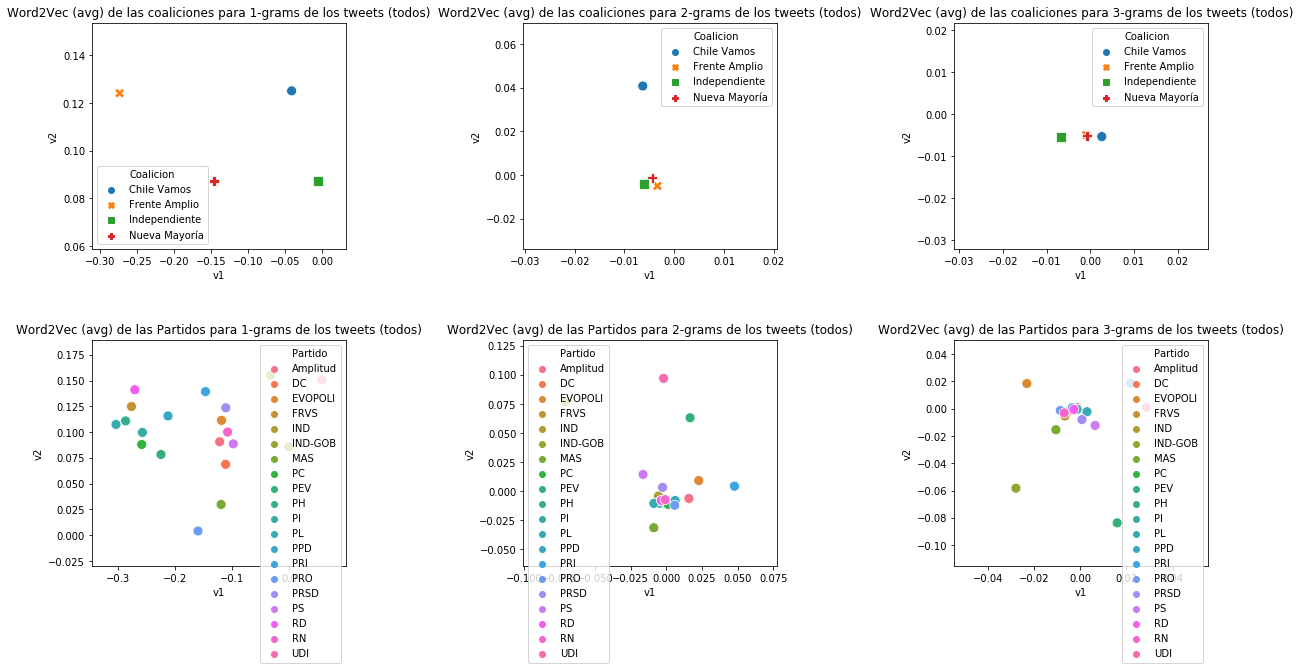

In [14]:
make_analisis(SDFv3)

Se observa que las mayores separaciones están dadas por 1-gram (bag of words), ya cuando hablamos de 2 y 3 grams, la derecha es la que más se diferencia del resto.

In [15]:
sdf_gram = NGram().setInputCol("stops_removed").setOutputCol("gram-1").setN(1).transform(SDFv3)
w2v_=Word2Vec(vectorSize=2,minCount=3,inputCol="gram-1",outputCol="word2vect")
model_ =w2v_.fit(sdf_gram)
result_=model_.transform(sdf_gram)
pdf_= result_.toPandas()
w2v_df = pd.DataFrame.from_records(pdf_.apply(getVector, axis=1))
pdf_['v1'] = w2v_df['v1']
pdf_['v2'] = w2v_df['v2']

In [16]:
pdf_1 =pdf_.groupby('Partido').mean()
pdf_2 =pdf_.groupby('Coalicion').mean()

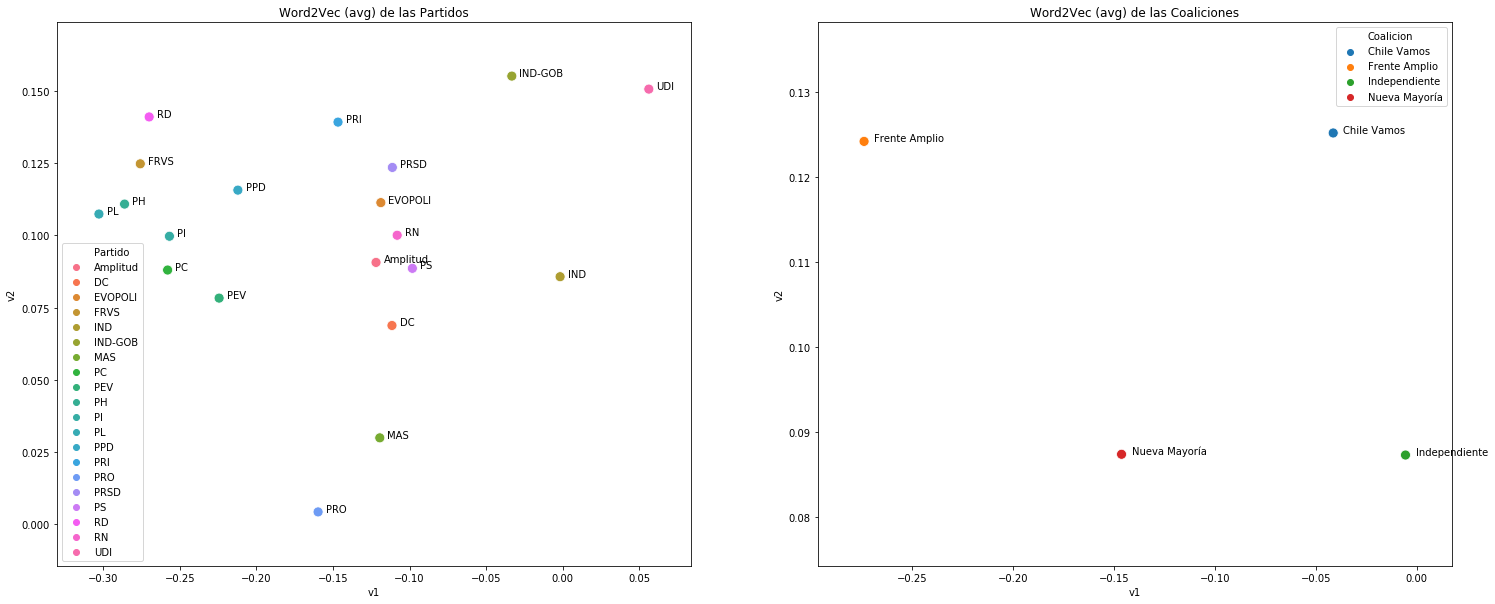

In [17]:
def label_point(x, y, val, ax):
    a = pd.concat({'x': x, 'y': y, 'val': val}, axis=1)
    for i, point in a.iterrows():
        ax.text(point['x']+.005, point['y'], str(point['val']))

        
pdf__ = pdf_1.reset_index()

fix, ax = plt.subplots(1,2,figsize=(25,10))
sns.scatterplot(x='v1',y='v2', data=pdf__, hue='Partido',ax=ax[0],  s=100, markers=True).set_title('Word2Vec (avg) de las Partidos')
label_point(pdf__.v1, pdf__.v2, pdf__.Partido, ax[0])  


pdf__ = pdf_2.reset_index()

sns.scatterplot(x='v1',y='v2', data=pdf__, hue='Coalicion',ax=ax[1],  s=100, markers=True).set_title('Word2Vec (avg) de las Coaliciones')
label_point(pdf__.v1, pdf__.v2, pdf__.Coalicion, ax[1])  

De momento se observa que podríamos entrenar un modelo considerando UDI por un lado y PL+PH+RD+FRVS+PI+PC por otro lado (izquierda) esto nos daría datasets de similar tamaño. Hay bastante separación entre ambos grupos en el sentido del uso de su vocabulario (simple bag of words)

## Separación de los Datasets

In [14]:
tweets_der = SDFv2.filter(SDFv2.Partido == 'UDI')
tweets_der.count()

31631

In [15]:
tweets_izq = SDFv2.filter((SDFv2.Partido == 'PL' )| (SDFv2.Partido == 'PH' )| (SDFv2.Partido == 'PC') | (SDFv2.Partido == 'RD') | (SDFv2.Partido == 'FRVS' ))
tweets_izq.count()

22571

## Checkpoint

In [16]:
tweets_der.write.mode('overwrite').parquet('tweets_derecha')
tweets_izq.write.mode('overwrite').parquet('tweets_izquierda')

## Subida S3

In [17]:
bucket = 'politicos-dataset-us-east-1'
region = 'us-east-1'
prefix = 'gpt2_fine_tune/tweets_derecha'
#tweets_der = spark.read.parquet('tweets_derecha')
tweets_der.write.mode('overwrite').parquet('s3a://{}/{}/parquet'.format(bucket,prefix))

In [18]:
prefix = 'gpt2_fine_tune/tweets_izquierda'
#tweets_izq = spark.read.parquet('tweets_izquierda')
tweets_izq.write.mode('overwrite').parquet('s3a://{}/{}/parquet'.format(bucket,prefix))